In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
base_path = './drive/My Drive/Colab Notebooks/Speech Denoising/Data/'

In [3]:
!pip install librosa

In [0]:
import librosa

In [0]:
s, sr=librosa.load(base_path + 'train_clean_male.wav', sr=None)
train_clean=librosa.stft(s, n_fft=1024, hop_length=512).T
sn, sr=librosa.load(base_path + 'train_dirty_male.wav', sr=None)
train_dirty=librosa.stft(sn, n_fft=1024, hop_length=512).T

In [0]:
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
train_clean.shape

(2459, 513)

In [0]:
import tensorflow as tf

In [0]:
train_clean_val = np.abs(train_clean)
train_dirty_val = np.abs(train_dirty)

In [10]:
print(f'min(train_clean_val) = {np.min(train_clean_val)}, max(train_clean_val) = {np.max(train_clean_val)}')
print(f'min(train_dirty_val) = {np.min(train_dirty_val)}, max(train_dirty_val) = {np.max(train_dirty_val)}')

min(train_clean_val) = 2.724569583278935e-07, max(train_clean_val) = 31.574600219726562
min(train_dirty_val) = 3.297913409028297e-08, max(train_dirty_val) = 31.603910446166992


In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_dirty_val, train_clean_val, test_size=0.2)

In [12]:
# Build neural network
X = tf.placeholder(dtype='float', shape=[None, 513])
y = tf.placeholder(dtype='float', shape=[None, 513])

in_units = 513
h1_units = 500
h2_units = 500
h3_units = 500
h4_units = 500
out_units = 513

# He initializer: mean = 0.0, stddev = sqrt(2/#in_nodes)
weights = {
    'w1': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[in_units, h1_units], mean=0.0, stddev=np.sqrt(2/in_units))),
    'w2': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[h1_units, h2_units], mean=0.0, stddev=np.sqrt(2/h1_units))),
    'w3': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[h2_units, h3_units], mean=0.0, stddev=np.sqrt(2/h2_units))),
    'w4': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[h3_units, h3_units], mean=0.0, stddev=np.sqrt(2/h3_units))),
    'out': tf.Variable(dtype='float', initial_value=tf.random_normal(shape=[h4_units, out_units], mean=0.0, stddev=np.sqrt(2/h4_units))),
}

bias_initial_value = 0.01
biases = {
    'b1': tf.Variable(initial_value=tf.ones([h1_units]) * bias_initial_value),
    'b2': tf.Variable(initial_value=tf.ones([h2_units]) * bias_initial_value),
    'b3': tf.Variable(initial_value=tf.ones([h3_units]) * bias_initial_value),
    'b4': tf.Variable(initial_value=tf.ones([h4_units]) * bias_initial_value),
    'out': tf.Variable(initial_value=tf.ones([out_units]) * bias_initial_value)
}

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
beta = 0.000

z1 = tf.add(tf.matmul(X, weights['w1']), biases['b1'])
a1 = tf.nn.relu(z1)

z2 = tf.add(tf.matmul(a1, weights['w2']), biases['b2'])
a2 = tf.nn.relu(z2)

z3 = tf.add(tf.matmul(a2, weights['w3']), biases['b3'])
a3 = tf.nn.relu(z3)

z4 = tf.add(tf.matmul(a2, weights['w3']), biases['b3'])
a4 = tf.nn.relu(z4)

logits = tf.add(tf.matmul(a4, weights['out']), biases['out'])
output = tf.nn.relu(logits)

regularizers = tf.nn.l2_loss(weights['w1']) + tf.nn.l2_loss(weights['w2']) + tf.nn.l2_loss(weights['w3']) + tf.nn.l2_loss(weights['out'])
mse = tf.losses.mean_squared_error(labels=y, predictions=output)
loss = tf.reduce_mean(mse + beta * regularizers)

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

train = optimizer.minimize(loss=loss)

# calculate accuracy
correct = tf.equal(tf.argmax(input=logits, axis=1), tf.argmax(input=y, axis=1))
accuracy = tf.reduce_mean(tf.cast(dtype='float', x=correct))

init = tf.global_variables_initializer()

Instructions for updating:
Use tf.cast instead.


In [14]:
batch_size = 1000
total_samples = X_train.shape[0]

train_acc, test_acc = [], []
train_loss, test_loss = [], []

sess = tf.Session()
  
sess.run(init)
for epoch in range(1, 10001):
  for itr in range(total_samples//batch_size + 1):
    start_idx = itr * batch_size
    end_idx = min((itr + 1) * batch_size, total_samples)
    batch_x, batch_y = X_train[start_idx:end_idx, :], y_train[start_idx:end_idx, :]
    sess.run(train, feed_dict={X: batch_x, y: batch_y})
    
  if epoch % 10 == 0:
    trls, trac = sess.run([loss, accuracy], feed_dict={X: batch_x, y: batch_y})
    tsls, tsac = sess.run([loss, accuracy], feed_dict={X: X_test, y: y_test})
#     plot_weight_distribution(weights)
    
    train_acc.append(trac)
    test_acc.append(tsac)
    train_loss.append(trls)
    test_loss.append(tsls)
    
    if epoch % 1000 == 0:
      print(f'Epoch:{epoch}')
      print(f'Train set:\tLoss:{trls:.4f},\tAccuracy:{trac:.4f}')
      print(f'Test set:\tLoss:{tsls:.4f},\tAccuracy:{tsac:.4f}\n')

Epoch:1000
Train set:	Loss:0.0034,	Accuracy:0.6122
Test set:	Loss:0.0077,	Accuracy:0.4065

Epoch:2000
Train set:	Loss:0.0030,	Accuracy:0.6484
Test set:	Loss:0.0077,	Accuracy:0.4207

Epoch:3000
Train set:	Loss:0.0029,	Accuracy:0.6711
Test set:	Loss:0.0078,	Accuracy:0.4309

Epoch:4000
Train set:	Loss:0.0028,	Accuracy:0.6784
Test set:	Loss:0.0078,	Accuracy:0.4390

Epoch:5000
Train set:	Loss:0.0026,	Accuracy:0.6980
Test set:	Loss:0.0078,	Accuracy:0.4289

Epoch:6000
Train set:	Loss:0.0026,	Accuracy:0.6991
Test set:	Loss:0.0079,	Accuracy:0.4289

Epoch:7000
Train set:	Loss:0.0025,	Accuracy:0.7115
Test set:	Loss:0.0079,	Accuracy:0.4207

Epoch:8000
Train set:	Loss:0.0024,	Accuracy:0.7694
Test set:	Loss:0.0080,	Accuracy:0.4411

Epoch:9000
Train set:	Loss:0.0024,	Accuracy:0.7890
Test set:	Loss:0.0081,	Accuracy:0.4329

Epoch:10000
Train set:	Loss:0.0023,	Accuracy:0.7859
Test set:	Loss:0.0080,	Accuracy:0.4309



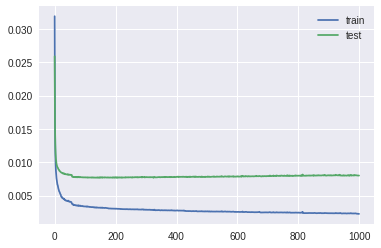

In [15]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.legend(['train', 'test'])

In [0]:
clean_Sv = sess.run(output, feed_dict={X: train_dirty_val, y: train_clean_val})

In [0]:
clean_Sv.shape

(2459, 513)

In [0]:
s, sr = librosa.load(base_path + 'test_x_01.wav', sr=None)
test1_dirty = librosa.stft(s, n_fft=1024, hop_length=512).T
test1_dirty_val = np.abs(test1_dirty)
test1_clean_val = sess.run(output, feed_dict={X: test1_dirty_val})

In [0]:
save_audio(test1_dirty.T, test1_dirty_val.T, test1_clean_val.T, base_path+'output.wav')

In [0]:
def save_audio(X, modX, S, filename):
    result = np.multiply(np.divide(X, modX), S)
    sh_test = librosa.istft(result, hop_length=512)
    librosa.output.write_wav(filename, sh_test, sr)

In [0]:
save_audio(train_dirty.T, train_dirty_val.T, clean_Sv.T, base_path+'output.wav')

In [0]:
train_dirty.shape, train_dirty_val.shape, clean_Sv.shape

((513, 2459), (513, 2459), (2459, 513))

In [0]:
train_dirty

array([[ 1.29152825e-02+0.0000000e+00j, -7.06597278e-03-1.0839904e-18j,
         3.11613153e-03+2.8036791e-19j, ...,
         5.43509632e-05-4.9720834e-19j, -4.78351954e-04+6.3675702e-19j,
         6.20555074e-04+0.0000000e+00j],
       [ 8.45048483e-03+0.0000000e+00j, -6.94738980e-03+5.1884386e-03j,
        -1.59678720e-02-1.7763563e-02j, ...,
        -4.15163022e-03-1.1022503e-03j,  2.63221073e-03-1.5408223e-03j,
        -3.61816579e-04+0.0000000e+00j],
       [-2.07481943e-02+0.0000000e+00j,  2.39305142e-02+3.3414264e-03j,
         8.85831192e-03+8.3497362e-03j, ...,
         1.19022408e-03-2.0613750e-03j,  7.62302428e-04+5.9353854e-03j,
        -1.19814684e-03+0.0000000e+00j],
       ...,
       [-1.52135687e-02+0.0000000e+00j,  1.20950164e-02-9.4868029e-03j,
        -1.23670641e-02+5.9306147e-03j, ...,
         5.36997162e-04+7.6431502e-04j, -3.81498365e-03-6.0208812e-03j,
         1.59274472e-03+0.0000000e+00j],
       [-4.98118671e-03+0.0000000e+00j, -3.12095246e-04-1.4751647e-0